# Notebook 2: Advanced Quantum Tomography
## Deep Learning (DNN) & Variational Quantum Circuits (VQC) vs. Classical SVR

## 1. Scientific Context & Exploration Goals
In the previous notebook, we established a robust baseline using **Support Vector Regression (SVR)**, a classical kernel-based method. While effective, SVR relies on fixed kernels (RBF, Polynomial) which may not perfectly capture the complex geometry of quantum states under decoherence.

In this second exploratory phase, we move towards **Advanced Architectures**. Our goal is to determine if models with higher representational capacity (Deep Learning) or native quantum priors (VQC) can surpass the classical baseline, particularly in the regime of **impure states (decoherence)** and **limited data**.

We investigate two challengers:
1.  **Deep Neural Networks (DNN):** Using the universal approximation theorem to model the mapping from measurements to density matrices with high non-linearity.
2.  **Variational Quantum Circuits (VQC):** A "Quantum Machine Learning" approach. We hypothesize that a quantum circuit possesses a natural *inductive bias* for quantum data, potentially requiring fewer parameters to represent the Hilbert space than a classical network.

## 2. A Paradigm Shift: "Physics-Informed" Training
Unlike standard regression which minimizes the Euclidean distance (MSE), we introduce a **Custom Loss Function** grounded in Quantum Information Theory.

### The "Fidelity-Based" Backpropagation
Standard ML optimizes geometry. We want to optimize **physics**.
Instead of blindingly minimizing $MSE = ||\vec{r}_{pred} - \vec{r}_{real}||^2$, we configure our Neural Networks (both Classical and Quantum) to directly maximize the **Quantum Fidelity** ($F$).

During the **Backpropagation** pass, the gradient of the Fidelity is computed with respect to the model weights. This forces the optimizer to prioritize directions that increase the physical overlap between the predicted and true states.

**The Mathematical Loss Function:**
For a single qubit state defined by a Bloch vector $\vec{r}$, the loss $\mathcal{L}$ to minimize is:

$$\mathcal{L} = 1 - F(\rho_{pred}, \rho_{real})$$

Where the Fidelity $F$ for single-qubit Bloch vectors is given analytically by:
$$F(\vec{r}_{p}, \vec{r}_{t}) = \frac{1}{2} \left( 1 + \vec{r}_{p} \cdot \vec{r}_{t} + \sqrt{(1 - ||\vec{r}_{p}||^2)(1 - ||\vec{r}_{t}||^2)} \right)$$

* **Interpretation:** The term $\vec{r}_{p} \cdot \vec{r}_{t}$ aligns the vectors directionally. The term under the square root penalizes errors in **purity** (vector length). This allows the DNN to specifically "learn" decoherence.

## 3. Architecture Overview

### A. Deep Neural Network (DNN - PyTorch)
* **Structure:** A Multi-Layer Perceptron (MLP) with fully connected layers and non-linear activation functions (ReLU).
* **Why:** To test if a "Universal Approximator" can learn the noise models better than fixed kernels.

### B. Variational Quantum Circuit (VQC - PennyLane)
* **Concept:** We use a parameterized quantum circuit as the model.
* **Mechanism:**
    1.  **Encoding:** Classical inputs ($X, Y, Z$) are embedded into a quantum state via rotation gates.
    2.  **Processing:** A sequence of trainable gates (Ansatz) manipulates the state.
    3.  **Measurement:** We measure the expectation values of Pauli operators to obtain the output vector.
* **Hypothesis:** "Quantum for Quantum". A quantum circuit naturally evolves on the Bloch sphere (or inside it for mixed states via subsystems), which might offer better generalization with fewer parameters.

## 4. Implementation: High-Performance Computing (GPU)
With SVC, we had quite some long training time. So in order to handle the computational load of training deep networks and simulating quantum circuits, we leverage **GPU Acceleration**:
* **PyTorch (CUDA/MPS):** For tensor operations and automatic differentiation of the DNN.
* **PennyLane Lightning GPU:** Using high-performance state-vector simulators (like `lightning.gpu` or `lightning.qubit`) to accelerate the VQC simulation and gradient calculation (adjoint differentiation).

We also do this as a way to learn modern high-performance ML pipelines.

## 5. Input/Output Interfaces
To ensure a rigorous comparison with the SVR baseline from Notebook 1, the I/O structure remains identical:

* **Input $\mathbf{X}$:** Noisy measurement expectations $[ \langle X \rangle_{noise}, \langle Y \rangle_{noise}, \langle Z \rangle_{noise} ]$.
* **Output $\mathbf{y}$:** Predicted Bloch vector components $[\hat{x}, \hat{y}, \hat{z}]$.

*Note: The predicted vector is implicitly constrained to valid physical states (norm $\le$ 1) either via activation functions (Tanh) or penalty terms in the loss.*

✅ Module saint_dtSet chargé avec succès.
✅ Computation Device: cuda

=== Lancement de l'exploration ===

--- Niveau de Décohérence : 0.0 ---
Baseline Fidelity: 0.9951
Training DNN... Done -> 0.9997
Training VQC... Done -> 1.0000

--- Niveau de Décohérence : 0.5 ---
Baseline Fidelity: 0.9962
Training DNN... Done -> 0.9801
Training VQC... Done -> 0.9665

--- Niveau de Décohérence : 0.9 ---
Baseline Fidelity: 0.9979
Training DNN... Done -> 0.9823
Training VQC... Done -> 0.9886

=== Terminé. Génération du graphique... ===


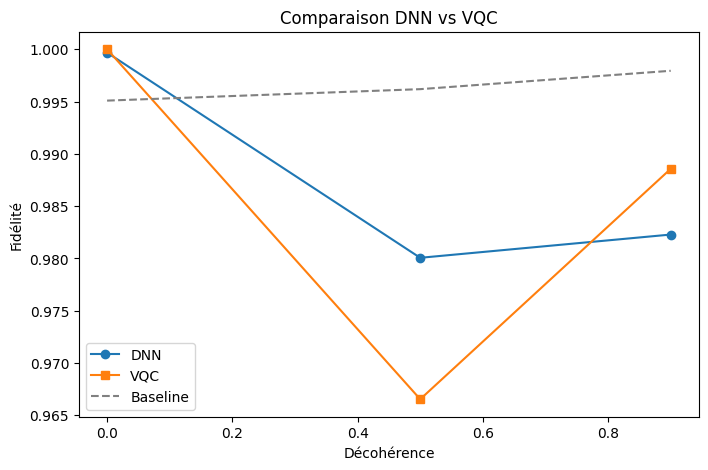

In [2]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pennylane as qml

# ------------------------------------------------------------------
# 0. IMPORT DES DONNÉES (Gestion d'erreur si le fichier manque)
# ------------------------------------------------------------------
try:
    # Essaie d'importer depuis le dossier courant
    from saint_dtSet import generate_qubit_tomography_dataset_base
    print("✅ Module saint_dtSet chargé avec succès.")
except ImportError:
    try:
        # Essaie d'importer depuis un sous-dossier
        from dataset_build.saint_dtSet import generate_qubit_tomography_dataset_base
        print("✅ Module dataset_build.saint_dtSet chargé avec succès.")
    except ImportError:
        print("❌ ERREUR CRITIQUE : Le fichier 'saint_dtSet.py' est introuvable.")
        print("Veuillez placer le fichier du Notebook 1 dans le même dossier.")
        # On définit une fonction dummy pour ne pas faire planter le script immédiatement
        # mais cela ne donnera pas de vrais résultats physiques.
        def generate_qubit_tomography_dataset_base(*args, **kwargs):
            raise FileNotFoundError("Impossible de générer les données sans saint_dtSet.py")

# ------------------------------------------------------------------
# 1. CONFIGURATION GPU
# ------------------------------------------------------------------
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

DEVICE = get_device()
torch.manual_seed(42)
np.random.seed(42)
print(f"✅ Computation Device: {DEVICE}")

# ------------------------------------------------------------------
# 2. OUTILS MATHÉMATIQUES & DATALOADERS (Définis AVANT usage)
# ------------------------------------------------------------------
def fidelity_from_bloch(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """Calcul de la fidélité entre vecteurs de Bloch prédits et réels."""
    dot = (pred * target).sum(dim=-1)
    norm_pred = (pred ** 2).sum(dim=-1)
    norm_target = (target ** 2).sum(dim=-1)
    # Clamp pour éviter les racines carrées négatives
    under_sqrt = torch.clamp(1.0 - norm_pred, min=0.0) * torch.clamp(1.0 - norm_target, min=0.0)
    fidelity = 0.5 * (1.0 + dot + torch.sqrt(under_sqrt))
    return torch.clamp(fidelity, 0.0, 1.0)

def build_dataloaders(df: pd.DataFrame, batch_size: int = 32):
    """Prépare les tenseurs PyTorch pour l'entraînement."""
    features = df[['X_mean', 'Y_mean', 'Z_mean']].to_numpy(dtype=np.float32)
    targets = df[['X_real', 'Y_real', 'Z_real']].to_numpy(dtype=np.float32)
    
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

    train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, (X_test, y_test)

def compute_baseline_fidelity(x_test, y_test):
    """Baseline simple : on suppose que Mesure = État (sans correction)."""
    preds = torch.from_numpy(x_test)
    targets = torch.from_numpy(y_test)
    return fidelity_from_bloch(preds, targets).mean().item()

# ------------------------------------------------------------------
# 3. LOSS FUNCTION (Défini AVANT l'entraînement)
# ------------------------------------------------------------------
class QuantumFidelityLoss(nn.Module):
    def __init__(self):
        super(QuantumFidelityLoss, self).__init__()

    def forward(self, y_pred, y_true):
        r2_pred = torch.sum(y_pred**2, dim=1).clamp(max=1.0 - 1e-6)
        r2_true = torch.sum(y_true**2, dim=1).clamp(max=1.0 - 1e-6)
        dot_prod = torch.sum(y_pred * y_true, dim=1)
        purity_term = torch.sqrt((1.0 - r2_pred) * (1.0 - r2_true))
        fidelity = 0.5 * (1.0 + dot_prod + purity_term)
        return (1.0 - fidelity).mean()

# ------------------------------------------------------------------
# 4. MODÈLES : DNN & VQC (Définis AVANT l'instanciation)
# ------------------------------------------------------------------

# --- Modèle A : DNN ---
class TomographyDNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=3):
        super(TomographyDNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh() # Tanh force [-1, 1]
        )

    def forward(self, x):
        return self.net(x)

# --- Modèle B : VQC (Quantum) ---
n_qubits = 3
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def quantum_circuit(inputs, weights):
    # 1. Encodage des données
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    
    # 2. Couches variationnelles
    # CORRECTION ICI : "Strongly" et non "Strong"
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    # 3. Mesures
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class TomographyVQC(nn.Module):
    def __init__(self, n_layers=2):
        super(TomographyVQC, self).__init__()
        # La forme des poids dépend du nombre de couches (L), qubits (M) et paramètres par rotation (3)
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.post_processing = nn.Linear(n_qubits, 3)

    def forward(self, x):
        x_q = self.q_layer(x)
        return torch.tanh(self.post_processing(x_q))

# ------------------------------------------------------------------
# 5. FONCTIONS D'ENTRAÎNEMENT
# ------------------------------------------------------------------
def train_model(model, train_loader, optimizer, loss_fn, epochs, device):
    model.to(device)
    loss_history = []
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        loss_history.append(epoch_loss)
    return loss_history

def evaluate_model(model, data_loader, device):
    model.eval()
    preds_list, targets_list = [], []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            preds_list.append(pred.cpu())
            targets_list.append(yb.cpu())
    preds_t = torch.cat(preds_list, dim=0)
    targets_t = torch.cat(targets_list, dim=0)
    return fidelity_from_bloch(preds_t, targets_t).mean().item()

# ------------------------------------------------------------------
# 6. BOUCLE PRINCIPALE (EXECUTION)
# ------------------------------------------------------------------
# C'est ici qu'on utilise tout ce qu'on a défini au-dessus.

# Paramètres
N_STATES = 1000  # Réduit pour aller vite
N_SHOTS = 500
DECOHERENCE_LEVELS = [0.0, 0.5, 0.9]
BATCH_SIZE = 32
EPOCHS_DNN = 15
EPOCHS_VQC = 8 # VQC est plus lent, on réduit
LR_DNN = 0.01
LR_VQC = 0.05

results = {"dnn": [], "vqc": [], "baseline": []}

print("\n=== Lancement de l'exploration ===")

for level in DECOHERENCE_LEVELS:
    print(f"\n--- Niveau de Décohérence : {level} ---")
    
    # 1. Génération
    df = generate_qubit_tomography_dataset_base(
        n_states=N_STATES, n_shots=N_SHOTS,
        include_decoherence=True, decoherence_level=level,
        mode="finite_shots", random_state=1234
    )
    
    # Appel de build_dataloaders (qui est bien défini plus haut)
    train_loader, test_loader, (x_test, y_test) = build_dataloaders(df, BATCH_SIZE)

    # 2. Baseline
    base_fid = compute_baseline_fidelity(x_test, y_test)
    results["baseline"].append(base_fid)
    print(f"Baseline Fidelity: {base_fid:.4f}")

    # 3. DNN
    print("Training DNN...", end="")
    # Appel de TomographyDNN (bien défini plus haut)
    dnn = TomographyDNN().to(DEVICE)
    opt = torch.optim.Adam(dnn.parameters(), lr=LR_DNN)
    # Appel de QuantumFidelityLoss (bien défini plus haut)
    train_model(dnn, train_loader, opt, QuantumFidelityLoss(), EPOCHS_DNN, DEVICE)
    dnn_fid = evaluate_model(dnn, test_loader, DEVICE)
    results["dnn"].append(dnn_fid)
    print(f" Done -> {dnn_fid:.4f}")

    # 4. VQC
    print("Training VQC...", end="")
    vqc = TomographyVQC(n_layers=2).to(DEVICE)
    opt_vqc = torch.optim.Adam(vqc.parameters(), lr=LR_VQC)
    train_model(vqc, train_loader, opt_vqc, QuantumFidelityLoss(), EPOCHS_VQC, DEVICE)
    vqc_fid = evaluate_model(vqc, test_loader, DEVICE)
    results["vqc"].append(vqc_fid)
    print(f" Done -> {vqc_fid:.4f}")

print("\n=== Terminé. Génération du graphique... ===")

plt.figure(figsize=(8, 5))
plt.plot(DECOHERENCE_LEVELS, results['dnn'], '-o', label='DNN')
plt.plot(DECOHERENCE_LEVELS, results['vqc'], '-s', label='VQC')
plt.plot(DECOHERENCE_LEVELS, results['baseline'], '--', color='gray', label='Baseline')
plt.xlabel('Décohérence')
plt.ylabel('Fidélité')
plt.legend()
plt.title('Comparaison DNN vs VQC')
plt.show()